In [1]:
%config InlineBackend.figure_format = 'svg'

# === IMPORTS ===

from typing import cast

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from pdfa import PDFA
import machines
import ffutils as ff
import variety as var
from ffutils import Model, TestConfig, TrainRun, TestRun, ModelType, EnsMode, VoteStrat
from export import import_pdfa_json
from clock import SimpleClock
from cache import Cache


# === GLOBAL OBJECTS ===

CORES = 12
CLOCK = SimpleClock()
CACHE = Cache()

STANDARD_TEST = ff.create_standard_config("test")
REBER_CONFIG = ff.create_standard_config("reber")
PARITY_CONFIG = ff.create_standard_config("parity")

def PAUTOMAC_SET(set_number: int):
    return TestConfig(
        name = f"pautomac_{set_number}",
        dir = "PAutomaC-competition_sets",
        train_suffix = ".pautomac.train.dat",
        model_suffix = ".pautomac.train.dat.ff",
        solution_suffix = ".pautomac_solution.txt",
        test_suffix = ".pautomac.test.dat"
    )

def RANDOM_CONFIG(id: int) -> TestConfig:
    return ff.create_standard_config(f"random_{id}", dir="random")

def RANDOM_MACHINE(id: int) -> PDFA:
    return import_pdfa_json(input_file=f"./../models/random_{id}.json")

In [2]:
# Now my objective is to train ensemble and single model on reber grammar with increasing training set sizes

def generate_sets_size_varied(config: TestConfig, pdfa: PDFA, train_sizes: list[int], test_size: int = 0) -> None:
    # Write increasingly bigger train sets
    trainset = []
    for size in train_sizes:
        trainset = ff.write_trainset(config, pdfa, f"{config.name}_{size}", size, append_to=trainset)
    # Write test set
    if test_size > 0:
        ff.write_testset(config, pdfa, f"{config.name}", test_size)


def evaluate_runs(config: TestConfig, train_runs: list[TrainRun], test_name: str, skip_training: bool = False):

    if not skip_training:
        # Train all models in a batch
        ff.train_models_batch(config, train_runs)
        print(f"Training {len(train_runs)} run configurations completed")
    else:
        print("Training models skipped")

    # List of perplexities per train run
    test_runs = TestRun.from_train_runs(train_runs, test_name)
    perplexities: list[float] = ff.test_models_batch(config, test_runs)
    print(f"Testing {len(test_runs)} run configurations on {test_name} completed")
    
    return perplexities


def plot_perplexity_by_train_size(models: list[Model], scores: dict[str, list[float]], train_sizes: list[int], plot_title: str = ""):

    # Plot the results
    plt.figure(figsize=(8, 5))
    colormap = plt.colormaps["cool"]
    get_color = lambda x : colormap(0.8 * (x + 1) / len(models))

    for i, (model_name, perplexities) in enumerate(scores.items()):
        plt.plot(train_sizes, perplexities, label=model_name, color=get_color(i))

    plt.title(f"Perplexity vs Training Set Size ({plot_title})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Perplexity")
    plt.xticks(train_sizes)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def evaluate_models_by_train_size(
        config: TestConfig, 
        pdfa: PDFA, 
        models: list[Model], 
        train_sizes: list[int], 
        test_size: int = 200, 
        plot_title: str|None = None, 
        skip_training: bool = False, 
        skip_generation: bool = False, 
        plotter=plot_perplexity_by_train_size
    ):

    # Set plot_title
    if not plot_title:
        plot_title = config.name

    # Generate the data for training and testing
    if not skip_training and not skip_generation:
        generate_sets_size_varied(config, pdfa, train_sizes, test_size)
        print(f"Generated {len(train_sizes)} train sets and a test set")
    else:
        print("Skipped generating training and test sets")

    # Prepare all training runs
    train_runs: list[TrainRun] = []
    for model in models:
        for train_size in train_sizes:
            run = model.into_run(run_name=f"{train_size}", trainset_name=f"{config.name}_{train_size}")
            train_runs.append(run)

    scores = evaluate_runs(config, train_runs, test_name=config.name, skip_training=skip_training)

    # Collect the scores per model
    perplexities: dict[str, list[float]] = {model.model_name: [] for model in models}
    i = 0
    for model in models:
        for _ in train_sizes:
            perplexities[model.model_name].append(scores[i])
            i += 1
    
    # Plot the scores
    plotter(models, perplexities, train_sizes, plot_title)


Generated 18 train sets and a test set
Training 54 run configurations completed
Testing 54 run configurations on reber completed


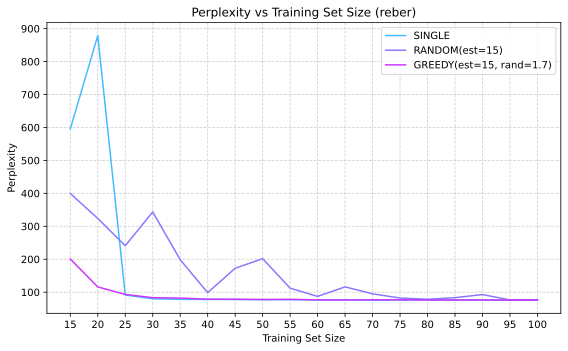

In [3]:
def eval_reber_single_random_greedy():

    reber_train_sizes = [i for i in range(15, 101, 5)]
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Random(model_name="RANDOM(est=15)", nrestimators=15),
        Model.Greedy(model_name="GREEDY(est=15, rand=1.7)", nrestimators=15, rand=1.7)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.reber(), models, reber_train_sizes, test_size=1000, skip_generation=False)

eval_reber_single_random_greedy()

Generated 10 train sets and a test set
Training 30 run configurations completed
Testing 30 run configurations on reber completed


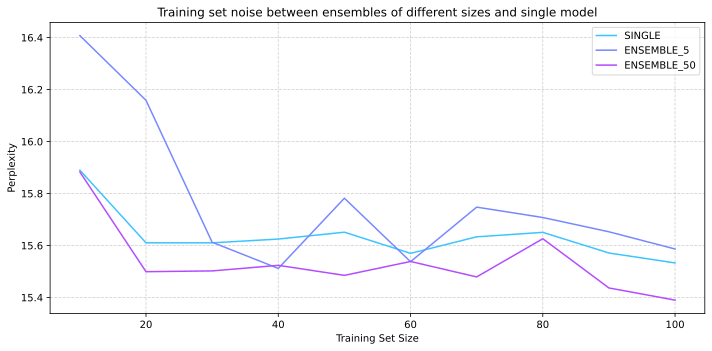

In [3]:
def plot_wide(models, scores, train_sizes, plot_title):

    # Plot the results
    plt.figure(figsize=(10, 5))
    colormap = plt.colormaps["cool"]
    get_color = lambda x : colormap(0.7 * (x + 1) / len(models))

    for i, (model_name, perplexities) in enumerate(scores.items()):
        plt.plot(train_sizes, perplexities, label=model_name, color=get_color(i))

    plt.title(f"Training set noise between ensembles of different sizes and single model")
    plt.xlabel("Training Set Size")
    plt.ylabel("Perplexity")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def eval_reber_by_train_size():

    reber_train_sizes = [i for i in range(10, 101, 10)]
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Random(model_name="ENSEMBLE_5", nrestimators=5),
        Model.Random(model_name="ENSEMBLE_50", nrestimators=50)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.parity_machine(), models, reber_train_sizes, test_size=500, plotter=plot_wide)

eval_reber_by_train_size()

Generated 9 train sets and a test set
Training 18 run configurations completed
Testing 18 run configurations on parity completed


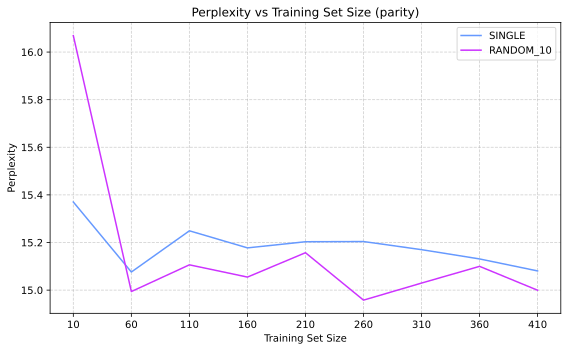

In [4]:
def eval_parity_by_train_size():

    parity_train_sizes = [i for i in range(10, 411, 50)]
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Random(model_name="RANDOM_10", nrestimators=10)
    ]
    evaluate_models_by_train_size(PARITY_CONFIG, machines.parity_machine(), models, parity_train_sizes, test_size=500)

eval_parity_by_train_size()

Generated 12 train sets and a test set
Training 24 run configurations completed
Testing 24 run configurations on random_1 completed


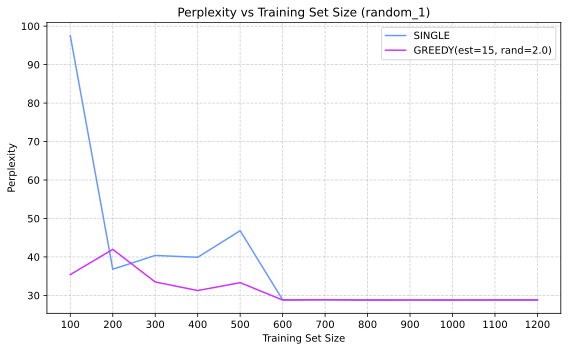

In [ ]:
# Now evaluate random 1
def evaluate_random_1():

    random_1 = import_pdfa_json(input_file="./../models/random_1.json")
    random_config = ff.create_standard_config("random_1", dir="random")
    train_sizes = [i for i in range(100, 801, 100)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.0)", nrestimators=15, rand=2.5)
    ]
    evaluate_models_by_train_size(random_config, random_1, models, train_sizes=train_sizes, test_size=test_size)

evaluate_random_1()

Generated 15 train sets and a test set
Training 30 run configurations completed
Testing 30 run configurations on random_2 completed


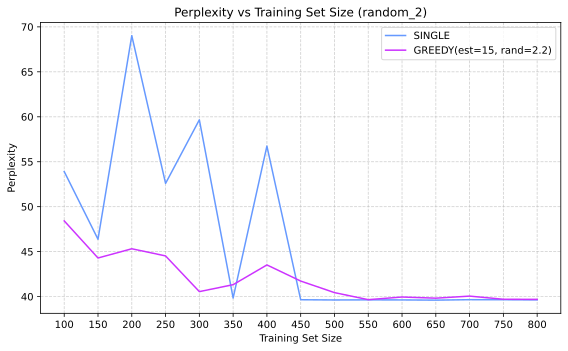

In [9]:
# Now evaluate random 2
def evaluate_random_2():

    random_2 = import_pdfa_json(input_file="./../models/random_2.json")
    random_config = ff.create_standard_config("random_2", dir="random")
    train_sizes = [i for i in range(100, 801, 50)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.2)", nrestimators=15, rand=2.2)
    ]
    evaluate_models_by_train_size(random_config, random_2, models, train_sizes=train_sizes, test_size=test_size)

evaluate_random_2()

Generated 8 train sets and a test set
Training 400 run configurations completed
Testing 400 run configurations on reber completed
Skipped generating training and test sets
Training 400 run configurations completed
Testing 400 run configurations on reber completed


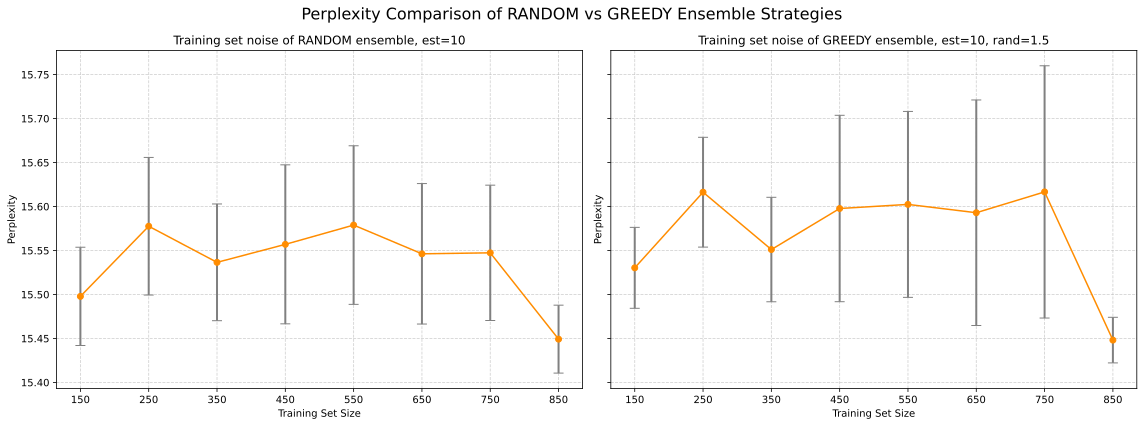

In [3]:
def plot_average_vs_trainsize(models, scores: dict[str, list[float]], train_sizes: list[int], plot_title, ax):

    # The data
    data = np.array(list(scores.values()), dtype=float)  # shape: (n_runs, training_sizes)
    means = data.mean(axis=0)
    stds = data.std(axis=0)

    # Plot
    ax.errorbar(train_sizes, means, yerr=stds, fmt='-o', capsize=5, color='darkorange', ecolor='gray', elinewidth=2)
    
    ax.set_title(f"Training set noise of {plot_title}")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("Perplexity")
    ax.set_xticks(train_sizes)
    ax.grid(True, linestyle='--', alpha=0.6)


def eval_reber_avg_random_vs_greedy():
    
    def into_plotter(ax):
        return lambda a, b, c, d: plot_average_vs_trainsize(a, b, c, d, ax=ax)

    # For plotting two graphs
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 2 plots, same y-axis

    # Run config
    reber_train_sizes = [i for i in range(150, 901, 100)]
    nrestimators = 10
    tries = 50
    test_size = 500

    models_random = [
        Model.Random(model_name=f"ENS_RAND_{i}", nrestimators=nrestimators) for i in range(tries)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.parity_machine(), models_random, reber_train_sizes, test_size=test_size, plotter=into_plotter(axs[0]), plot_title="RANDOM ensemble, est=10")

    models_greedy = [
        Model.Greedy(model_name=f"ENS_GREEDY_{i}", nrestimators=nrestimators, rand=1.5) for i in range(tries)
    ]
    evaluate_models_by_train_size(REBER_CONFIG, machines.parity_machine(), models_greedy, reber_train_sizes, test_size=test_size, plotter=into_plotter(axs[1]), plot_title="GREEDY ensemble, est=10, rand=1.5", skip_generation=True)

    # For plotting the graphs
    fig.suptitle("Perplexity Comparison of RANDOM vs GREEDY Ensemble Strategies", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # leave space for the suptitle
    plt.show()

eval_reber_avg_random_vs_greedy()

In [4]:
def evaluate_single_vs_ensemble(config: TestConfig, test_name: str, train_name: str):

    labels = ['SINGLE', 'ENSEMBLE']
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Random(model_name="ENSEMBLE_10", nrestimators=10)
    ]
    scores = []

    for model in models:
        train_run = model.into_run(trainset_name=train_name)
        ff.train_model(config, train_run)
        test_run = train_run.into_test(test_name)
        score = ff.test_model(config, test_run)
        scores.append(score)

    colors = ["blue", "orange"]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, scores, color=colors)

    # Annotate the bars with the score values
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{score:.5f}', ha='center', va='bottom')

    plt.ylabel("Perplexity Score")
    plt.title(f"SINGLE vs ENSEMBLE Perplexity ({test_name})")
    plt.ylim(0, max(scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_model_scores(config: TestConfig, runs: list[TestRun], test_name: str):

    scores = ff.test_models_batch(config, runs)
    labels = [run.run_name for run in runs]

    plt.figure(figsize=(10, 8))
    bars = plt.bar(labels, scores)

    # Annotate the bars with the score values
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{score:.5f}', ha='center', va='bottom')

    plt.ylabel("Perplexity")
    plt.title(f"Perplexity comparison ({test_name})")
    plt.ylim(0, max(scores) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


Generated 9 train sets and a test set
Training 18 run configurations completed
Testing 18 run configurations on random_3 completed


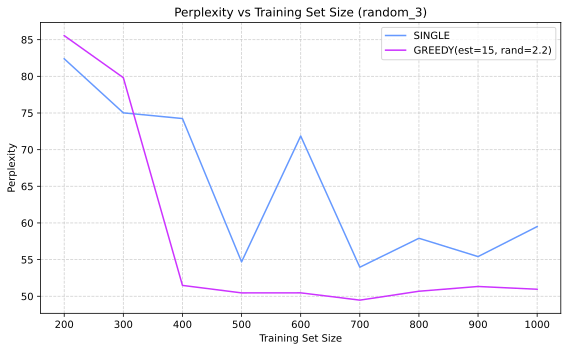

In [14]:
# Now evaluate random 3
def evaluate_random_3():

    train_sizes = [i for i in range(200, 1001, 100)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.2)", nrestimators=15, rand=2.2)
    ]
    evaluate_models_by_train_size(RANDOM_CONFIG(3), RANDOM_MACHINE(3), models, train_sizes=train_sizes, test_size=test_size)

evaluate_random_3()

In [13]:
def evaluate_runs_imv(config: TestConfig, train_runs: list[TrainRun], opt_runs: list[TrainRun], test_runs: list[TestRun], sample_size: int = 200, skip_training: bool = False):

    if not skip_training:
        # Train all models in a batch
        ff.train_models_batch(config, train_runs)
        print(f"Training {len(train_runs)} run configurations completed")
        ff.diff_models_batch(config, opt_runs, sample_size)
        print(f"Optimizing weights of {len(opt_runs)} run configurations completed")
    else:
        print("Training and optmizing models skipped")

    # List of perplexities per train run
    perplexities: list[float] = ff.test_models_batch(config, test_runs)
    print(f"Testing {len(test_runs)} run configurations completed")
    
    return perplexities


def flat_scores_into_dict(scores_flat: list[float], test_models: list[Model], num_train_sizes: int):

    scores: dict[str, list[float]] = {model.model_name: [] for model in test_models}
    i = 0
    for model in test_models:
        for _ in range(num_train_sizes):
            scores[model.model_name].append(scores_flat[i])
            i += 1
    return scores



def evaluate_models_by_train_size_imv(
        config: TestConfig, 
        pdfa: PDFA, 
        models_to_train: list[Model],
        models_to_optimize: list[Model],
        models_to_test: list[Model],
        train_sizes: list[int], 
        test_size: int = 200, 
        plot_title: str|None = None, 
        skip_training: bool = False, 
        skip_generation: bool = False,
        sample_size: int = 200,
        plotter=plot_perplexity_by_train_size
    ):

    # Set plot_title
    if not plot_title:
        plot_title = config.name

    # Generate the data for training and testing
    if skip_training or skip_generation:
        print("Skipped generating training and test sets")
    else:
        generate_sets_size_varied(config, pdfa, train_sizes, test_size)
        print(f"Generated {len(train_sizes)} train sets and a test set")

    # Prepare all training runs
    train_runs: list[TrainRun] = []
    opt_runs: list[TrainRun] = []
    test_runs: list[TestRun] = []

    for model in models_to_train:
        for train_size in train_sizes:
            run = model.into_run(run_name=f"{train_size}", trainset_name=f"{config.name}_{train_size}")
            train_runs.append(run)

    for model in models_to_optimize:
        for train_size in train_sizes:
            run = model.into_run(run_name=f"{train_size}", trainset_name=f"{config.name}_{train_size}")
            opt_runs.append(run)

    for model in models_to_test:
        for train_size in train_sizes:
            run = model.into_test(run_name=f"{train_size}", testset_name=config.name)
            test_runs.append(run)
    
    # Run all of the configurations
    flat_scores = evaluate_runs_imv(config, train_runs, opt_runs, test_runs, sample_size, skip_training=skip_training)

    # Collect the scores per test model
    scores_dict = flat_scores_into_dict(flat_scores, models_to_test, len(train_sizes))
    
    # Plot the scores
    plotter(models_to_test, scores_dict, train_sizes, plot_title)

In [14]:
# Evaluate random 3 with custom weights
def evaluate_custom_weights(
        config = RANDOM_CONFIG(3), 
        pdfa = RANDOM_MACHINE(3),
        train_sizes = [i for i in range(100, 801, 50)],
        test_size = 1000,
        sample_size = 500,
        nrestimators = 40,
        rand = 4.0
    ):


    train_models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY UNIFORM", model_file="GREEDY", nrestimators=nrestimators, rand=rand),
    ]
    opt_models = [
        Model.Weighted(model_name="GREEDY WEIGHTED", model_file="GREEDY", nrestimators=nrestimators)
    ]
    test_models = train_models + opt_models

    evaluate_models_by_train_size_imv(
        config=config,
        pdfa=pdfa,
        models_to_train=train_models,
        models_to_test=test_models,
        models_to_optimize=opt_models,
        train_sizes=train_sizes,
        test_size=test_size,
        sample_size=sample_size,
        skip_generation=True,
        skip_training=True
    )


Skipped generating training and test sets
Training and optmizing models skipped
Running command: ['C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\cmake-build-debug-visual-studio\\flexfringe.exe', '--mode', 'pred_single', '--ini', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\ini\\alergia.ini', '--outputfile', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\out_random_3\\100.result', '--aptafile', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\out_random_3\\SINGLE_100_training.txt', '--solution', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\random_3_solution.txt', '--nrestimators', '1', '--votestrat', 'uniform', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\random_3_test.txt']
Running command: ['C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\cmake-build-debug-visual-studio\\flexfringe.exe', '--mode', 'pred_single', '--ini', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\ini\\alergia.ini', '--outputfile', 'C:\\users

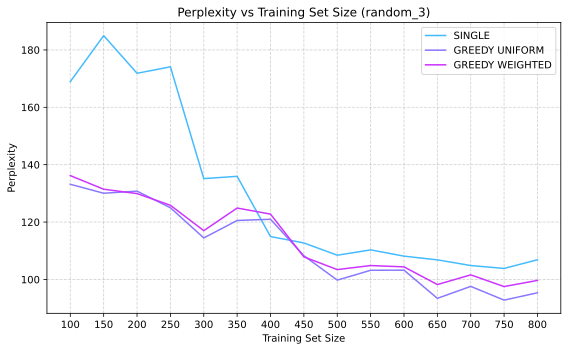

In [15]:
evaluate_custom_weights()

Generated 20 train sets and a test set
Training 40 run configurations completed
Optimizing weights of 20 run configurations completed
Testing 60 run configurations completed


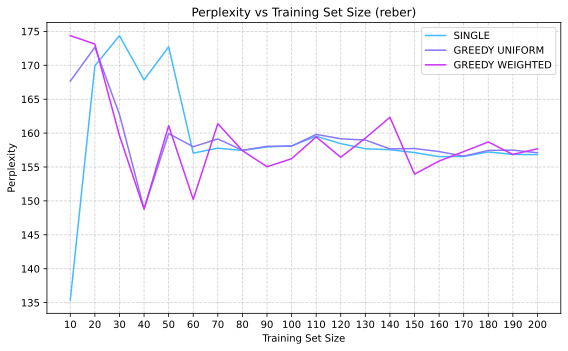

In [22]:
evaluate_custom_weights(
    config=REBER_CONFIG,
    pdfa=machines.reber(),
    train_sizes= [i for i in range(10, 201, 10)],
    test_size=300,
    sample_size=300,
    nrestimators=10,
    rand=3
)

Skipped generating training and test sets
Training models skipped
Testing 16 run configurations on random_4 completed


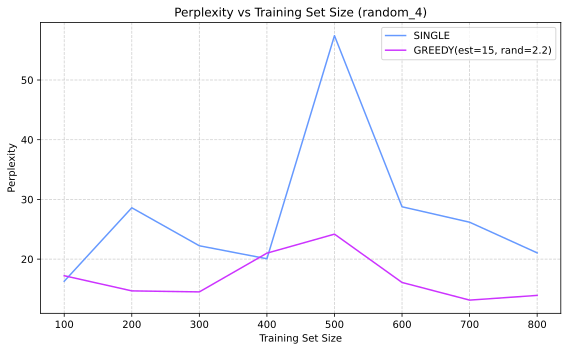

In [9]:
# Now evaluate random 4
def evaluate_random_4():

    train_sizes = [i for i in range(100, 801, 100)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.2)", nrestimators=15, rand=2.2)
    ]
    evaluate_models_by_train_size(
        RANDOM_CONFIG(4), 
        RANDOM_MACHINE(4), 
        models, 
        train_sizes=train_sizes, 
        test_size=test_size, 
        skip_generation=True, 
        skip_training=True
    )


evaluate_random_4()

Generated 10 train sets and a test set
Training 20 run configurations completed
Testing 20 run configurations on random_5 completed


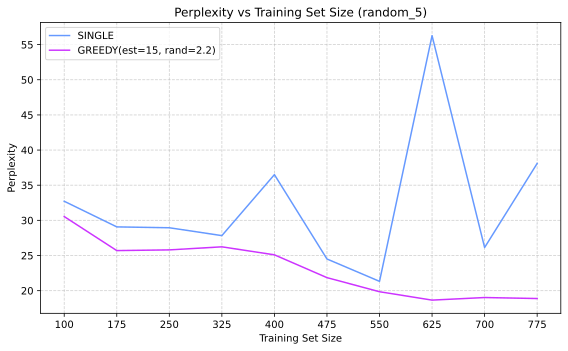

In [7]:
# Now evaluate random 5
def evaluate_random_5():

    train_sizes = [i for i in range(100, 801, 75)]
    test_size = 500
    models = [
        Model.Single(model_name="SINGLE"),
        Model.Greedy(model_name="GREEDY(est=15, rand=2.2)", nrestimators=15, rand=2.2)
    ]
    evaluate_models_by_train_size(
        RANDOM_CONFIG(5), 
        RANDOM_MACHINE(5), 
        models, 
        train_sizes=train_sizes, 
        test_size=test_size, 
        skip_generation=False, 
        skip_training=False
    )

evaluate_random_5()

In [2]:
def test_pautomac(set_number: int, skip_train = False, big_ens_size = 20, small_ens_size = 10):

    config = PAUTOMAC_SET(set_number)
    set_name = str(set_number)

    single = Model.Single("SINGLE")
    greedy = Model.Greedy(f"GREEDY_{big_ens_size}", nrestimators=big_ens_size, rand = 3.0)

    # Train single optmal model and an ensemble of random models
    if not skip_train:
        train_runs = greedy.split_into_parallel_runs(trainset_name=set_name) + [single.into_run(trainset_name=set_name)]
        ff.train_models_batch(config, train_runs, number_of_cores=11)

    # Create pruned ensemble
    diff_run = greedy.into_run(trainset_name=set_name)
    H_flat = ff.diff_model(config, diff_run, sample_size=1000)
    H = var.scores_flat_to_normalized_cross_entropy(H_flat, big_ens_size)
    small_model = var.prune_ensemble(H, big_ens_size, small_ens_size)

    # Test 3 models
    test_runs = [
        single.into_test(testset_name=set_name),
        greedy.into_test(testset_name=set_name, run_name=f"GREEDY(est={big_ens_size}, rand=3.0)"),
        greedy.into_test(testset_name=set_name, ens_models=small_model, run_name=f"PRUNED(est={small_ens_size})")
    ]

    plot_model_scores(config, test_runs, f"PAutomaC set {set_name}")


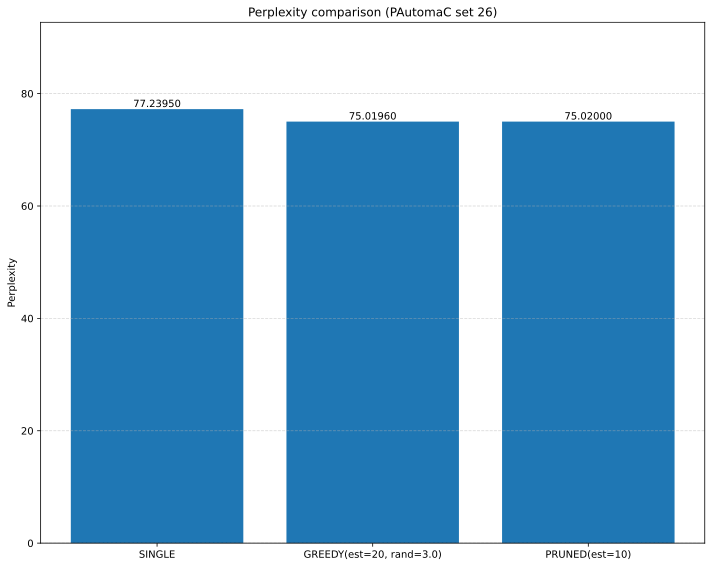

In [10]:
test_pautomac(26, skip_train=True)

In [ ]:
test_pautomac(19) # This ran for 3 hours and didn't produce even a single model

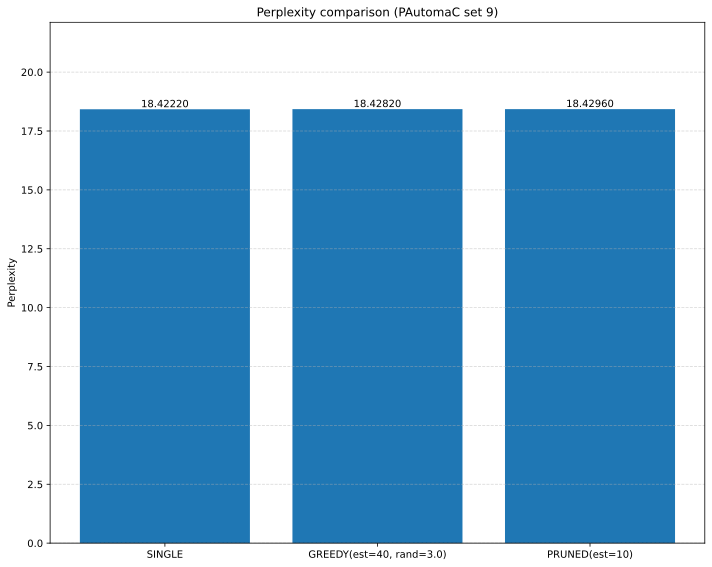

In [11]:
test_pautomac(9, big_ens_size=40, skip_train=True)

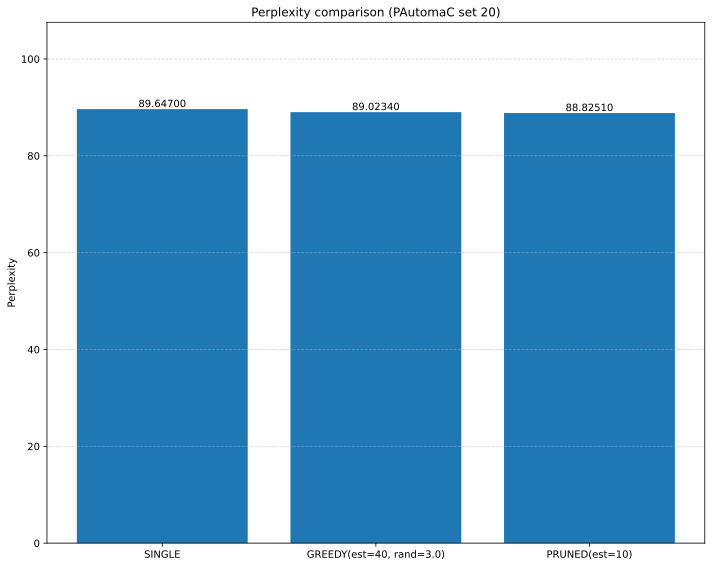

In [12]:
test_pautomac(20, big_ens_size=40, skip_train=True)